# _Computational Linguistics_ Code

In [1]:
# mount google drive
from google.colab import drive
import os

drive.mount('/content/drive/')

Drive already mounted at /content/drive/; to attempt to forcibly remount, call drive.mount("/content/drive/", force_remount=True).


In [2]:
# load the excel data
import pandas as pd
import matplotlib.colors as mc # For the legend
import matplotlib.pyplot as plt
import matplotlib.colors
import numpy as np

# IU-token Class Definition

In [3]:
class CSTokenMetricsComparisons:
  def __init__(self, data, n_languages=2, IU_tag_col_name="Clean Lang Tag", word_tag_col_name = "Words Lang Tag", text_col_name="IU no punctuation"):
    self.df = data
    self.IU_tag_col_name = IU_tag_col_name
    self.word_tag_col_name = word_tag_col_name
    self.text_col_name = text_col_name
    self.n_languages = n_languages
    self.IU_lang_visualizations = []
    """
    Dictionary storing all the ingo we will eventually populate. Entry examples include:
    - total_rows      : how many IUs are there in the transcript? (int)
    - IU_lang_rows    : language tags per IU after filtering non- S/E/L (list of strs)
    - L_count         : how many lone items are present? (list of ints, counting Ls per IU)
    - within-switch   : # of within IU CS (diff. based on the token) (int)
    - across-switch   : # of of across IU CS (int)
    - prosodic-switch : counting CS based on language and IU sentence (dict of SE/ES counts)
    """
    self.data_dict = {
        "IU"  : {
            "multi": {},
            "both" : {}
        },
        "word": {
            "multi": {},
            "both" : {}
        }
    }


  """
  This function should get called first, to populate the data_dict structure.
  """
  def process_raw_info(self, CS_type="multi", token_level="IU"):
    prev_letter = ""
    raw_counts = {
        "total_valid_rows": 0,    # rows counted after filtering for desired language tags
        "total_rows"      : 0,
        "lang_tag_counts" : {
                             "S": 0,
                             "E": 0,
                            },
        "L_count"         : [],   # how many IUs have Ls? (and how many?)
        "IU_lang_rows"    : [],   # language tag measurements after filtering out non- S/E/L
    }

    # get appropriate data column
    data_rows = None
    if token_level == "IU":
      data_rows = self.df[self.IU_tag_col_name].astype(str)
    elif token_level == "word":
      data_rows = self.df[self.word_tag_col_name].astype(str)
    else:
      raise Exception("Did not enter a valid token level. Please enter either 'IU' or 'word'.")

    # loop through every IU row in the transcript
    for i in range(len(data_rows)):
      # we want to filter out anything that isn't L or S or E (depending on our 'include_L' flag)
      curr_row = data_rows[i]
      curr_row = [x for x in curr_row if x in ["L", "S", "E"]]
      if len(curr_row) > 0:
        raw_counts["total_valid_rows"] += 1

      # count the Ls in the current IU row
      if CS_type == "both":
        L_count = curr_row.count("L")
        raw_counts["L_count"].append(L_count)

      # process every tag in the IU
      curr_tags = []
      for lang_idx, lang in enumerate(curr_row):

        # this will only happen once for each for loop / IU row;
        if (token_level == "IU" and lang_idx == 0) or token_level == "word":
          # properly increment the lang tag counts (currently for the IU)
          if lang == "S":
            raw_counts["lang_tag_counts"]["S"] += 1
          elif lang == "E":
            raw_counts["lang_tag_counts"]["E"] += 1

        # populate the filtered language tags properly; if L, switch it according to the second param!
        if lang == "L":
          if prev_letter == "E":
            if CS_type == "both": # it counts as CS, so we will switch it
              curr_tags.append("L")
            else:
              curr_tags.append("E")
          elif prev_letter == "S":
            if CS_type == "both":
              curr_tags.append("L")
            else:
              curr_tags.append("S")
        else:
          curr_tags.append(lang)

        prev_letter = lang

      raw_counts["IU_lang_rows"].append(curr_tags)

    raw_counts["total_rows"] = len(raw_counts["IU_lang_rows"])

    self.data_dict[token_level][CS_type] = raw_counts
    return raw_counts

  """
  NOTES:
  - This function does count the Ls.
  - Because of that, some IUs from the total_valid_rows number don't actually count (i.e.,
      if an IU starts with an L, for example).
  """
  def m_index(self, CS_type="multi", token_level="IU"):
    # add a check here that throws an error in case they haven't processed raw counts yet
    if len(self.data_dict[token_level][CS_type]) == 0:
      raise Exception("Data hasn't been processed! Please call process_raw_counts with the same parameters before calling this function.")

    lang_counts = self.data_dict[token_level][CS_type]["lang_tag_counts"]
    lang_counts = [lang_counts["E"], lang_counts["S"]]

    # NOTE: Different number than self.data_dict[token_level][CS_type]["total_valid_rows"], which will also count a row as valid if it starts with an L (which we don't count here in our total).
    total_rows = lang_counts[0] + lang_counts[1]

    for i in range(len(lang_counts)):
      lang_counts[i] /= total_rows
      lang_counts[i] = lang_counts[i] ** 2

    p_sum = lang_counts[0] + lang_counts[1]
    self.M_index = (1 - p_sum) / ((self.n_languages - 1) * p_sum)

    return self.M_index

  def across_IU(self, CS_type="multi", token_level="IU"):
    if len(self.data_dict[token_level][CS_type]) == 0:
      raise Exception("Data hasn't been processed! Please call process_raw_counts with the same parameters before calling this function.")

    tag_cols = self.data_dict[token_level][CS_type]["IU_lang_rows"]
    prev = ""
    total, switch_count = 0, 0
    for row in tag_cols:
      if len(row) > 0:
        total += 1
      for i, tag in enumerate(row):
        if i == 0 and prev != "" and prev != tag and prev != "L":
          switch_count += 1
        prev = tag
    self.data_dict[token_level][CS_type]["across-switch"] = switch_count

    return switch_count, total

  """
  Remember: this is a binary count that only counts once if a switch is present within the IU.
  """
  def within_IU(self, CS_type="multi", token_level="IU"):
    if len(self.data_dict[token_level][CS_type]) == 0:
      raise Exception("Data hasn't been processed! Please call process_raw_counts with the same parameters before calling this function.")

    tag_cols = self.data_dict[token_level][CS_type]["IU_lang_rows"]

    total, switch_count = 0, 0
    for row in tag_cols:
      if len(row) > 0:
        total += 1
        # the below is to ensure we don't double count, since an L will already be considerd as an across IU switch
        if row[0] == "L":
          row = row[1:]
        unique_tags = set("".join(row))
        if len(unique_tags) > 1:
          switch_count += 1
    self.data_dict[token_level][CS_type]["within-switch"] = switch_count

    return switch_count, total

  def i_index(self, CS_type="multi", token_level="IU"):
    if len(self.data_dict[token_level][CS_type]) == 0:
      raise Exception("Data hasn't been processed! Please call process_raw_counts with the same parameters before calling this function.")

    if token_level == "IU":
      return self.__iu_i_index__(CS_type, token_level)
    elif token_level == "word":
      return self.__word_i_index__(CS_type, token_level)
    raise Exception("Invalid token level. Pleaseuse either 'IU' or 'word'.")

  """
  This function calculates the normal I-Index using word tokens by going through
  the transcript in sequential order. We only print the result, and don't return.
  """
  def __word_i_index__(self, CS_type="multi", token_level="IU"):
    tag_cols = self.data_dict[token_level][CS_type]["IU_lang_rows"]

    prev = ""
    total, switch_count = 0, 0
    for row in tag_cols:
      for tag in row:
        total += 1
        # remember, we aren't counting switching out of a lone tag.
        if prev != "" and prev != tag and prev != "L":
          switch_count += 1
        prev = tag

    i_index = switch_count / (total - 1)

    self.data_dict[token_level][CS_type]["CS-count"] = switch_count
    self.data_dict[token_level][CS_type]["I-index"] = i_index
    return switch_count, i_index

  def __iu_i_index__(self, CS_type="multi", token_level="IU"):
    # within IU only
    within_count, within_total = self.within_IU(CS_type, token_level)
    across_count, across_total = self.across_IU(CS_type, token_level)

    numerator = across_count + within_count - (across_count * (within_count / within_total))
    i_index = numerator / max(within_total, across_total)

    self.data_dict[token_level][CS_type]["CS-count"] = numerator
    self.data_dict[token_level][CS_type]["I-Index"] = i_index
    return numerator, i_index

  def count_CS_prosodic(self, CS_type="multi", token_level="IU"):
    if len(self.data_dict[token_level][CS_type]) == 0:
      raise Exception("Data hasn't been processed! Please call process_raw_counts with the same parameters before calling this function.")

    tag_cols = self.data_dict[token_level][CS_type]["IU_lang_rows"]
    word_col = self.df[self.text_col_name].astype(str).tolist()

    prev = ""
    SE, ES, total = 0, 0, 0
    for i, tags in enumerate(tag_cols):
      for j, tag in enumerate(tags):
        if prev != "" and prev != tag: # there's a switch!
          # is it within the prosodic boundary?
          # the first condition checks if we're the 1st tag in our row AND the
          # previous character of the transcription line isn't the end of a prosodic
          # sentence. the second condition is if we're not the first tag in the IU.

          if (j == 0 and word_col[i - 1][-1] not in [".", "?"]) or j > 0:
              total += 1
              if prev == "E" and tag == "S":
                ES += 1
              elif prev == "S" and tag == "E":
                SE += 1
              elif tag == "L":
                if prev == "E":
                  ES += 1
                elif prev == "S":
                  SE += 1
              elif prev == "L":
                total -= 1
        prev = tag
    assert (total == SE + ES)

    self.data_dict[token_level][CS_type]['prosodic-CS'] = {
        "SE"    : SE,
        "ES"    : ES,
        "total" : total
    }
    return SE, ES

  def visualize_transcript(self, CS_type="multi", token_level="IU", cmap_colors=["#0a437a", "#ADD8E6"], filepath="", save=False):
    if len(self.data_dict[token_level][CS_type]) == 0:
      raise Exception("Data hasn't been processed! Please call process_raw_counts with the same parameters before calling this function.")

    tag_cols = self.data_dict[token_level][CS_type]["IU_lang_rows"]
    # tags_merged = [tag for tags in tag_cols for tag in tags if tag in ["S", "E"]]
    # tags_merged = np.asarray(tags_merged)
    # print(tags_merged)
    # lang_distr = np.where(tags_merged == "E", 0, 1)

    lang_distributions = []
    for tags in tag_cols:
      for tag in tags:
        if tag == "E":
          lang_distributions.append(0)
        elif tag == "S":
          lang_distributions.append(1)
    # print(lang_distr)
    lang_distributions = np.asarray(lang_distributions).reshape(1, len(list(lang_distributions)), order="F")
    fig, ax = plt.subplots(figsize=(8, 4))

    if len(cmap_colors) != self.n_languages:
      raise Exception(f"Number of colors for plot should match # of languages, i.e., {self.n_languages}.")

    cmap = matplotlib.colors.ListedColormap(cmap_colors)
    ax.pcolormesh(lang_distributions, cmap=cmap)
    ax.set_frame_on(False)
    plt.yticks([])
    ax.set_ylim(top=0.5)

    if save:
      plt.savefig(filepath)
    return

# Example w/ Transcript

In [4]:
filepath = "/content/drive/MyDrive/Code-Switching-Work/updated-data/"
file = "15LasCosasViejas_for Rebecca-WORDS-updated.csv"
df = pd.read_csv(filepath + file)

In [5]:
metrics = CSTokenMetricsComparisons(df)

In [6]:
""" IU METRICS: just have to fix the count_CS_prosodic """

# print the file we're working with
print(f"Processing IU token for file {file}...\n")

# populate the S/E counts
no_L_IU = metrics.process_raw_info(CS_type="multi")
L_IU    = metrics.process_raw_info(CS_type="both")

print(f"Total number of IUs: {no_L_IU['total_rows']}\n")

# print the S/E counts
print(f"# of IUs as S: {no_L_IU['lang_tag_counts']['S']} \n#of IUs as E:{no_L_IU['lang_tag_counts']['E']}\n")

# Calculate the M-Index
m_index = metrics.m_index()
print(f"M-Index: {round(m_index, 2)}\n")

# Calculate the I-Indeces
CS_num_no_Ls, no_Ls_I_index = metrics.i_index()
CS_num_Ls, Ls_I_index = metrics.i_index(CS_type="both")

print(f"Estimated numerator for multi-word CS (IU level): {round(CS_num_no_Ls, 2)} \nIU-Index: {round(no_Ls_I_index, 2)}\n")
print(f"Estimated numerator when including Ls as CS (IU level): {round(CS_num_Ls, 2)} \nIU-Index: {round(Ls_I_index, 2)}\n")

# get the prosodic CS
SE, ES = metrics.count_CS_prosodic(CS_type="both")
print(f"Prosodic CS: \nSE: {SE} \nES: {ES}")

Processing IU token for file 15LasCosasViejas_for Rebecca-WORDS-updated.csv...

Total number of IUs: 2815

# of IUs as S: 538 
#of IUs as E:1723

M-Index: 0.57

Estimated numerator for multi-word CS (IU level): 347.11 
IU-Index: 0.15

Estimated numerator when including Ls as CS (IU level): 378.29 
IU-Index: 0.17

Prosodic CS: 
SE: 165 
ES: 193


In [7]:
""" WORD METRICS: check """

print(f"Processing word token for file {file}...\n")

# populate the S/E counts
no_L_raw_counts = metrics.process_raw_info(token_level="word", CS_type="multi")
L_raw_counts    = metrics.process_raw_info(token_level="word",CS_type="both")

print(f"Total number of words: {no_L_raw_counts['total_rows']}\n")

# print the S/E counts
print(f"# of words as S: {no_L_raw_counts['lang_tag_counts']['S']}")
print(f"# of words as E: {no_L_raw_counts['lang_tag_counts']['E']}\n")

# Calculate the I-Indeces
CS_num_no_Ls, no_Ls_I_index = metrics.i_index(token_level="word")
CS_num_Ls, Ls_I_index = metrics.i_index(token_level="word", CS_type="both")

print(f"# of multi-word CS (word level): {CS_num_no_Ls} \nI-Index including Ls as CS (word level): {no_Ls_I_index}\n")
print(f"# of CS wheh including Ls as CS (word level): {CS_num_Ls} \nI-Index when including Ls as CS (word level): {Ls_I_index}")

Processing word token for file 15LasCosasViejas_for Rebecca-WORDS-updated.csv...

Total number of words: 2815

# of words as S: 1563
# of words as E: 6678

# of multi-word CS (word level): 350 
I-Index including Ls as CS (word level): 0.04223992276128409

# of CS wheh including Ls as CS (word level): 385 
I-Index when including Ls as CS (word level): 0.046463915037412505


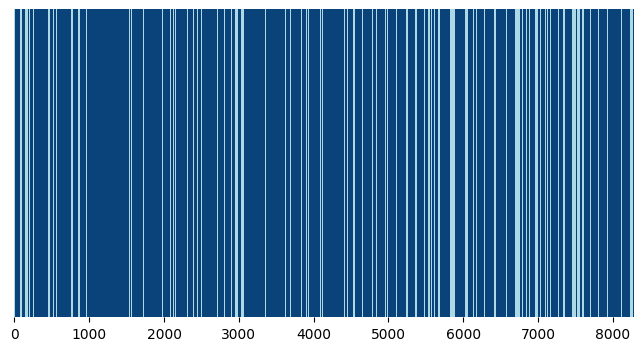

In [8]:
# visualize the word-based transcripts
metrics.visualize_transcript(token_level="word", CS_type="multi")

# Clustering Comparison across Presicion

In [9]:
from sklearn.metrics import davies_bouldin_score
from sklearn.cluster import AgglomerativeClustering

In [10]:
files = ['05LasTortillas_For Rebecca_Feb2023', '27ClimateChange_For Rebecca_Feb2023', '10ElTimbrePortatil_For Rebecca_Feb2023', '16.1TripToAfrica_for Rebecca', '03DosComadres_For Rebecca_Feb2023', '8.1-2GraduacionFamiliar_for Rebecca', '11 ElTrabajo_for Rebecca', '23ElPacifico_for Rebecca', '15LasCosasViejas_for Rebecca', '26LaPesca_for Rebecca']
word_ending = "-WORDS-updated.csv"

In [11]:
i_indexes = {
    "IU"  : [],
    "word": []
}

for file in files:
  df = pd.read_csv(filepath + file + word_ending)
  metrics = CSTokenMetricsComparisons(df)

  metrics.process_raw_info(token_level="IU", CS_type="multi")
  metrics.process_raw_info(token_level="word", CS_type="multi")

  _, iu_i_index = metrics.i_index(token_level="IU", CS_type="multi")
  _, word_i_index = metrics.i_index(token_level="word", CS_type="multi")

  i_indexes["IU"].append(iu_i_index)
  i_indexes["word"].append(word_i_index)

In [12]:
sigfigs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14]
linkage_types = ["ward", "complete", "average", "single"]
tokens = ["IU", "word"]

cluster_metrics = {}

for linkage in linkage_types:
  model = AgglomerativeClustering(linkage=linkage, n_clusters=3)

  for token in tokens:
    # extract the I-Indexes from the dictionary
    vals = i_indexes[token]

    def cluster_by_precision(figs):
      # round the values by significant digits
      rounded_vals = list(map(lambda x: round(x, figs), vals))
      rounded_vals = np.asarray(rounded_vals).reshape(-1, 1)

      # Step 2: cluster the files for each token
      labels = model.fit(rounded_vals).labels_
      #return labels

      # Step 3: compute the davis_bouldin_score
      return davies_bouldin_score(rounded_vals, labels)

    cluster_metrics[(linkage, token)] = list(map(cluster_by_precision, sigfigs))
  cluster_metrics[(linkage, "difference")] = list(map(lambda a, b: a - b, cluster_metrics[(linkage, "IU")], cluster_metrics[(linkage, "word")]))
  print(cluster_metrics)

{('ward', 'IU'): [np.float64(0.1925925925925931), np.float64(0.20546319515391875), np.float64(0.2051609119712405), np.float64(0.20497816592392848), np.float64(0.20498923902147767), np.float64(0.20498863517958757), np.float64(0.20498855257917345), np.float64(0.20498853895827204), np.float64(0.20498853983720025), np.float64(0.20498853956004426), np.float64(0.20498853960389574), np.float64(0.20498853960377783), np.float64(0.2049885396040081)], ('ward', 'word'): [np.float64(0.2929292929292924), np.float64(0.2099946836788913), np.float64(0.20224727963999076), np.float64(0.20188704961790402), np.float64(0.20187877360249482), np.float64(0.20186351783627385), np.float64(0.20186320162597068), np.float64(0.20186311553896416), np.float64(0.20186310718079192), np.float64(0.20186310798692983), np.float64(0.20186310808763328), np.float64(0.20186310808311125), np.float64(0.2018631080838216)], ('ward', 'difference'): [np.float64(-0.10033670033669928), np.float64(-0.004531488524972538), np.float64(0.00

In [13]:
df = pd.DataFrame.from_dict(cluster_metrics)
df.index = sigfigs
df = df.T
df = df.reset_index()

<Axes: title={'center': 'Differences of DBI across precision'}, xlabel='Number of significant figures', ylabel='Difference in clustering score (IU-based - word-based)'>

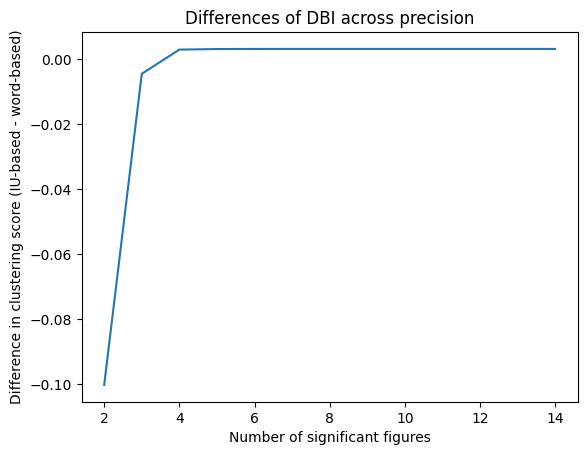

In [14]:
difference_mask = df['level_1'] == "difference"
differences = df[difference_mask]
differences = differences.rename(columns={"level_0": "linkage type"})
differences = differences.set_index(differences['linkage type'])
differences = differences.drop(columns=['linkage type', 'level_1'])
differences.loc[["average"]].T.plot.line(title="Differences of DBI across precision", xlabel="Number of significant figures", ylabel="Difference in clustering score (IU-based - word-based)", legend=False)